# Step 1: Import Libraries

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [18]:
# Define relevant variables for the ML task
num_classes = 10
# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Define Dataset and Transformations

In [19]:
# Loading the dataset and preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1325,), std=(0.3105,))
])

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=train_transforms,
    download=True
)

# Step 3: Define Model

LeNet5

In [20]:
# class LeNet5(nn.Module):
#     def __init__(self, num_classes):
#         super(LeNet5, self).__init__()
#         # Convulational layer 1
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(6)
#         self.relu1 = nn.ReLU()
#         # Convulational layer 2
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.relu2 = nn.ReLU()
#         # Fully connected layer 1
#         self.fc1 = nn.Linear(in_features=400, out_features=120)
#         self.relu3 = nn.ReLU()
#         # Fully connected layer 2
#         self.fc2 = nn.Linear(in_features=120, out_features=84)
#         self.relu4 = nn.ReLU()
#         # Fully connected layer 3
#         self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
#
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = F.max_pool2d(x, 2, 2)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = F.max_pool2d(x, 2, 2)
#         x = x.reshape(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.relu3(x)
#         x = self.fc2(x)
#         x = self.relu4(x)
#         x = self.fc3(x)
#         return x

In [21]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # Padding added
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(6) # Batch norm after activation
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16) # Batch norm after activation
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)  # Corrected flattening
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)  # No activation here!

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

In [22]:
model = LeNet5(num_classes).to(device)
input_size = (1, 32, 32)
with torch.no_grad():
    x = model.conv1(torch.randn(1, *input_size).to(device))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = model.conv2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    print(x.shape)
    print(16 * 5 *5)

torch.Size([1, 16, 5, 5])
400


# Step 4: Implement K-Fold Cross Validation

In [23]:
# Calculate in_features for the first fully connected layer
input_size = (1, 32, 32)
model = LeNet5(num_classes).to(device)

with torch.no_grad():
    sample_input = torch.randn(1, *input_size).to(device)
    output = model.conv1(sample_input)
    output = F.max_pool2d(output, kernel_size=2, stride=2)
    output = model.conv2(output)
    output = F.max_pool2d(output, kernel_size=2, stride=2)
    in_features = output.numel()
print(in_features)

400


In [24]:
# Constants
CONFIG = {
    "k_folds": 5,
    "batch_size": 64,
    "num_epochs": 10,
    "learning_rate": 0.001,
}


# Training and Validation Utilities
def initialize_training_pipeline(num_classes, device):
    model = LeNet5(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion


def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0.0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    return avg_loss, accuracy


# Main Cross-Validation Training Loop
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

kfold = KFold(n_splits=CONFIG["k_folds"], shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold + 1}')
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=CONFIG["batch_size"])

    model, optimizer, criterion = initialize_training_pipeline(num_classes, device)

    for epoch in range(CONFIG["num_epochs"]):
        print(f'Epoch {epoch + 1}')
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

avg_train_loss = sum(train_losses) / len(train_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print(f'Average Train Loss: {avg_train_loss:.4f}, Average Train Acc: {avg_train_acc:.4f}')
print(f'Average Val Loss: {avg_val_loss:.4f}, Average Val Acc: {avg_val_acc:.4f}')


Fold 1
Epoch 1
Train Loss: 0.3152, Train Acc: 0.9001
Val Loss: 0.1454, Val Acc: 0.9551
Epoch 2
Train Loss: 0.1283, Train Acc: 0.9596
Val Loss: 0.1088, Val Acc: 0.9668
Epoch 3
Train Loss: 0.1031, Train Acc: 0.9675
Val Loss: 0.0951, Val Acc: 0.9710
Epoch 4
Train Loss: 0.0889, Train Acc: 0.9725
Val Loss: 0.0902, Val Acc: 0.9722
Epoch 5
Train Loss: 0.0786, Train Acc: 0.9757
Val Loss: 0.0835, Val Acc: 0.9739
Epoch 6
Train Loss: 0.0766, Train Acc: 0.9762
Val Loss: 0.0767, Val Acc: 0.9752
Epoch 7
Train Loss: 0.0692, Train Acc: 0.9777
Val Loss: 0.0777, Val Acc: 0.9751
Epoch 8
Train Loss: 0.0649, Train Acc: 0.9787
Val Loss: 0.0720, Val Acc: 0.9782
Epoch 9
Train Loss: 0.0644, Train Acc: 0.9795
Val Loss: 0.0653, Val Acc: 0.9806
Epoch 10
Train Loss: 0.0607, Train Acc: 0.9806
Val Loss: 0.0696, Val Acc: 0.9789
Fold 2
Epoch 1
Train Loss: 0.3279, Train Acc: 0.8970
Val Loss: 0.1659, Val Acc: 0.9486
Epoch 2
Train Loss: 0.1365, Train Acc: 0.9567
Val Loss: 0.1246, Val Acc: 0.9613
Epoch 3
Train Loss: 0.104

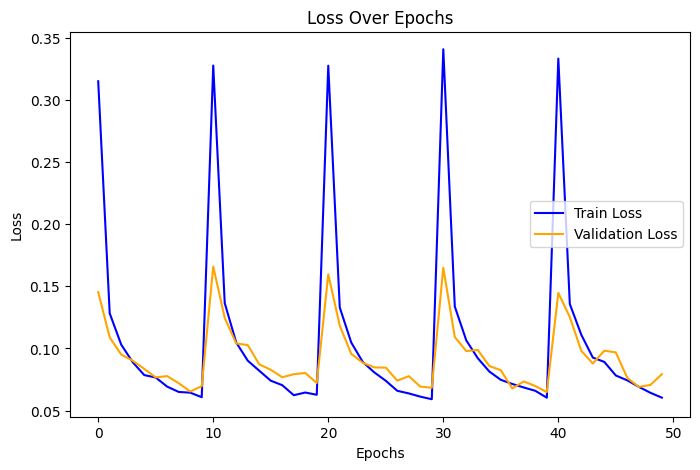

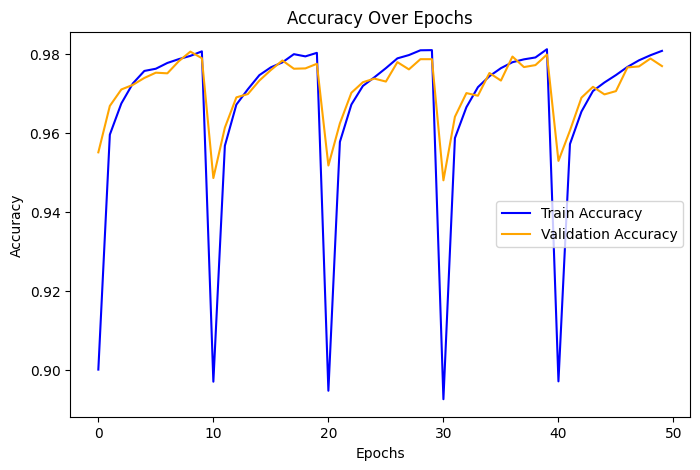

In [25]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()